## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15485499421957410476
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280806708
locality {
  bus_id: 1
  links {
  }
}
incarnation: 567290250388556419
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('./Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('./Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('./Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('./Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('./Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

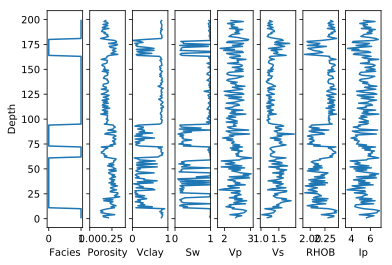

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True)

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


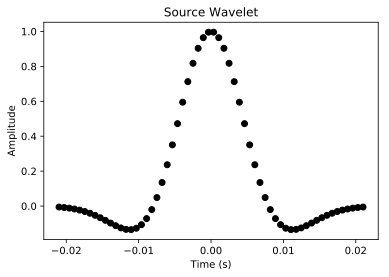

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, 'ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [8]:
# Convert all logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/Vp[i,:]*1e-3)

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

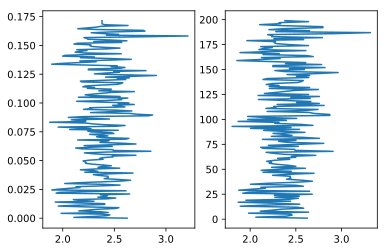

In [9]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


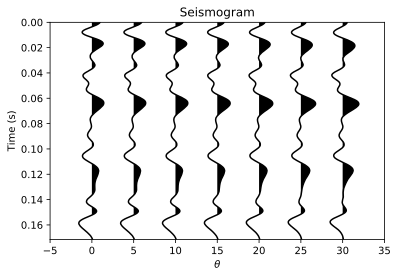

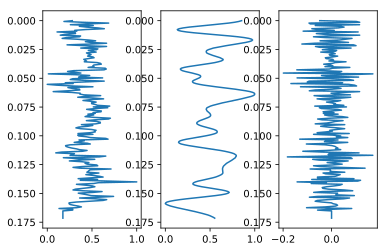

In [10]:
# Forward modeling results (Seismic gathers)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [11]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [12]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

# Concatenate Vp, Vs and Density 
num_examples = Vp_time.shape[0]
emodel = np.concatenate((Vp_time,Vs_time,RHOB_time), axis=1)
emodel = emodel.reshape((num_examples, 3, nt))


# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]
petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
petromodel = petromodel.reshape((num_examples, 3, ndepth))

# Split data into train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 7, 246, 1)
Y_train shape: (2000, 3, 246)
X_test shape: (500, 7, 246, 1)
Y_test shape: (500, 3, 246)


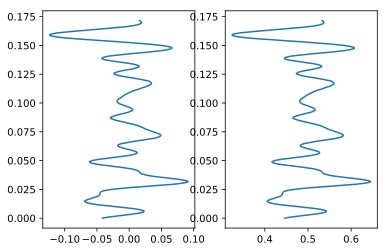

In [13]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [14]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (3, 45), strides=(1, 1), name='conv0', padding = 'same',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((3, 3), strides=(1,1),name='max_pool0', padding = 'same')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (3, 45), strides=(1, 1), name='conv1', padding = 'same',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((5, 1), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(246*3, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((3, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [15]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


In [16]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 7, 246, 60)        8160      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 7, 246, 60)        240       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 246, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 246, 1)         8101      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 7, 246, 1)         4         
_________________________________________________________________
activation_2 (Activation)    (None, 7, 246, 1)         0         
__________

In [ ]:
# # Learning rate scheduler
# from keras.callbacks import LearningRateScheduler
# # learning rate schedule
# def step_decay(epoch):
#     initial_lrate = 0.01
#     drop = 0.1
#     epochs_drop = 250.0
#     lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#     return lrate

In [94]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [95]:
# Start the training
# # Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [lrate]
# history = AVOModel.fit(X_train, Y_train, validation_split=0.1, epochs=1000, batch_size=32, callbacks=callbacks_list)

history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, epochs=1500, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/1500
1600/1600 [==============================] - 8s 5ms/step - loss: 1.5488 - val_loss: 0.9947
Epoch 2/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9235 - val_loss: 1.0837
Epoch 3/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9180 - val_loss: 1.0487
Epoch 4/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9159 - val_loss: 1.0341
Epoch 5/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9154 - val_loss: 1.0049
Epoch 6/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9151 - val_loss: 0.9742
Epoch 7/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9149 - val_loss: 0.9630
Epoch 8/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9147 - val_loss: 0.9468
Epoch 9/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.9145 - val_loss: 0.9415
Epoch 10/1500
160

1600/1600 [==============================] - 7s 4ms/step - loss: 0.7741 - val_loss: 0.7782
Epoch 156/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7740 - val_loss: 0.7768
Epoch 157/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7741 - val_loss: 0.7769
Epoch 158/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7740 - val_loss: 0.7772
Epoch 159/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7720 - val_loss: 0.7654
Epoch 160/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7599 - val_loss: 0.7632
Epoch 161/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7595 - val_loss: 0.7628
Epoch 162/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7595 - val_loss: 0.7624
Epoch 163/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7585 - val_loss: 0.7599
Epoch 164/1500
1600/1600 [==============================] - 7

1600/1600 [==============================] - 7s 4ms/step - loss: 0.6545 - val_loss: 0.6586
Epoch 310/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6545 - val_loss: 0.6587
Epoch 311/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6545 - val_loss: 0.6590
Epoch 312/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6545 - val_loss: 0.6589
Epoch 313/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6545 - val_loss: 0.6591
Epoch 314/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6544 - val_loss: 0.6590
Epoch 315/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6544 - val_loss: 0.6587
Epoch 316/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6544 - val_loss: 0.6594
Epoch 317/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.6545 - val_loss: 0.6588
Epoch 318/1500
1600/1600 [==============================] - 7

1600/1600 [==============================] - 7s 4ms/step - loss: 0.4890 - val_loss: 0.4948
Epoch 464/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4948
Epoch 465/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4945
Epoch 466/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4949
Epoch 467/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4948
Epoch 468/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4946
Epoch 469/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4948
Epoch 470/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4944
Epoch 471/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.4889 - val_loss: 0.4947
Epoch 472/1500
1600/1600 [==============================] - 7

1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2533
Epoch 618/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2534
Epoch 619/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2467 - val_loss: 0.2534
Epoch 620/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2536
Epoch 621/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2539
Epoch 622/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2539
Epoch 623/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2465 - val_loss: 0.2534
Epoch 624/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2535
Epoch 625/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.2466 - val_loss: 0.2537
Epoch 626/1500
1600/1600 [==============================] - 7

1600/1600 [==============================] - 7s 4ms/step - loss: 0.1590 - val_loss: 0.1779
Epoch 772/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1591 - val_loss: 0.1674
Epoch 773/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1590 - val_loss: 0.1685
Epoch 774/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1590 - val_loss: 0.1677
Epoch 775/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1590 - val_loss: 0.1697
Epoch 776/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1590 - val_loss: 0.1683
Epoch 777/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1591 - val_loss: 0.1698
Epoch 778/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1589 - val_loss: 0.1694
Epoch 779/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1590 - val_loss: 0.1675
Epoch 780/1500
1600/1600 [==============================] - 7

1600/1600 [==============================] - 7s 4ms/step - loss: 0.1438 - val_loss: 0.1542
Epoch 926/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1438 - val_loss: 0.1586
Epoch 927/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1437 - val_loss: 0.1540
Epoch 928/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1438 - val_loss: 0.1577
Epoch 929/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1437 - val_loss: 0.1604
Epoch 930/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1438 - val_loss: 0.1570
Epoch 931/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1437 - val_loss: 0.1554
Epoch 932/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1438 - val_loss: 0.1540
Epoch 933/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1438 - val_loss: 0.1558
Epoch 934/1500
1600/1600 [==============================] - 7

1600/1600 [==============================] - 7s 4ms/step - loss: 0.1080 - val_loss: 0.1285
Epoch 1079/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1081 - val_loss: 0.1239
Epoch 1080/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1080 - val_loss: 0.1200
Epoch 1081/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1080 - val_loss: 0.1339
Epoch 1082/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1080 - val_loss: 0.1246
Epoch 1083/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1079 - val_loss: 0.1267
Epoch 1084/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1081 - val_loss: 0.1286
Epoch 1085/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1080 - val_loss: 0.1204
Epoch 1086/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.1081 - val_loss: 0.1201
Epoch 1087/1500
1600/1600 [==========================

1600/1600 [==============================] - 7s 4ms/step - loss: 0.0970 - val_loss: 0.1110
Epoch 1231/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0970 - val_loss: 0.1143
Epoch 1232/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0970 - val_loss: 0.1251
Epoch 1233/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0971 - val_loss: 0.1123
Epoch 1234/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0970 - val_loss: 0.1111
Epoch 1235/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0971 - val_loss: 0.1214
Epoch 1236/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0972 - val_loss: 0.1132
Epoch 1237/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0971 - val_loss: 0.1121
Epoch 1238/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0970 - val_loss: 0.1120
Epoch 1239/1500
1600/1600 [==========================

1600/1600 [==============================] - 7s 4ms/step - loss: 0.0735 - val_loss: 0.0908
Epoch 1383/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0735 - val_loss: 0.0932
Epoch 1384/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0735 - val_loss: 0.1011
Epoch 1385/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0736 - val_loss: 0.0931
Epoch 1386/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0736 - val_loss: 0.0892
Epoch 1387/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0734 - val_loss: 0.0890
Epoch 1388/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0736 - val_loss: 0.0888
Epoch 1389/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0734 - val_loss: 0.0889
Epoch 1390/1500
1600/1600 [==============================] - 7s 4ms/step - loss: 0.0735 - val_loss: 0.0890
Epoch 1391/1500
1600/1600 [==========================

In [96]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 1s 3ms/step

Loss = 0.09124785697460175


0.14775758481025697

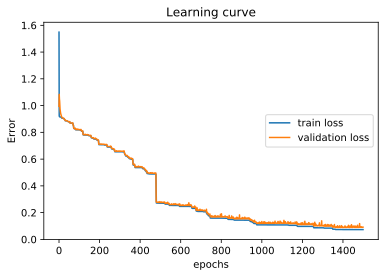

In [97]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [102]:
# Save trained model 
# serialize model to JSON
model_json = ElasticModel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticModel.save_weights("ElasticModel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load saved model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ElasticModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

In [99]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

(1.5, 3)

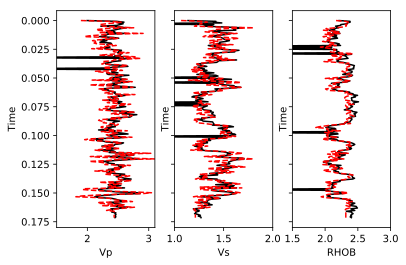

In [100]:
# Checking training data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Vp")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1,2)

axarr[2].plot(train_output[sample_number, 2, :], time_upscaled, '-k')
axarr[2].plot(Y_train[sample_number, 2, :], time_upscaled, '--r')
axarr[2].set_xlabel("RHOB")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
axarr[2].set_xlim(1.5,3)

(1.5, 3)

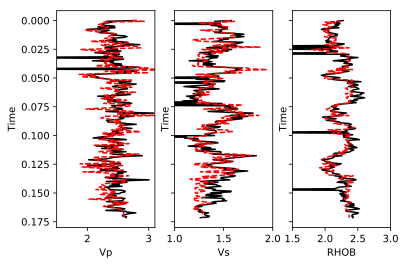

In [101]:
# Checking training data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Vp")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1,2)

axarr[2].plot(test_output[sample_number, 2, :], time_upscaled, '-k')
axarr[2].plot(Y_test[sample_number, 2, :], time_upscaled, '--r')
axarr[2].set_xlabel("RHOB")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
axarr[2].set_xlim(1.5,3)

In [59]:
time[1,1] - time[1,0]

0.0009932346197514064

In [36]:
Y_train.shape

(2000, 3, 246)